<a href="https://colab.research.google.com/github/peteray-dev/GAN_Painter/blob/master/CYCLEGAN_I_AM_SOMETHING_OF_A_PAINTER_MYSELF_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Translating a generated image into a real image using GAN**

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [3]:

!kaggle competitions download gan-getting-started


 94% 346M/367M [00:02<00:00, 136MB/s]
100% 367M/367M [00:02<00:00, 152MB/s]


In [4]:
!mkdir gan-getting-started.zip

!mv /content/gan-getting-started.zip* /content/gan-getting-started

mkdir: cannot create directory ‘gan-getting-started.zip’: File exists


 **GAN PROCESS**

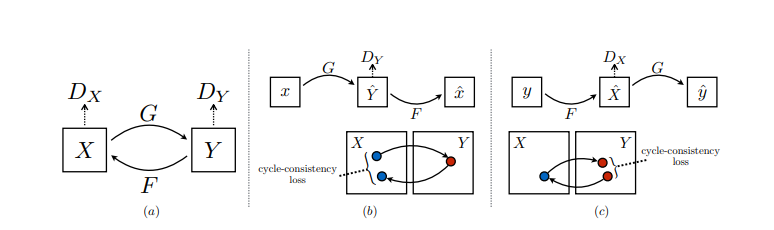

In [5]:
! unzip "/content/gan-getting-started"

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

In [6]:
# pip install torch-lr-finder -q

In [7]:
# Import necessary packages.
import numpy as np
import cv2
from PIL import Image
import random

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset, Dataset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# from torch_lr_finder import LRFinder

# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Example usage
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

])

monet_dataset = CustomImageDataset(img_dir="/content/monet_jpg", transform=transform)
photo_dataset = CustomImageDataset(img_dir="/content/photo_jpg", transform=transform)

In [9]:
monet_dataset[0].shape

torch.Size([3, 256, 256])

In [10]:
print(f"Monet dataset: {len(monet_dataset)}")
print(f"photo dataset: {len(photo_dataset)}")

Monet dataset: 300
photo dataset: 7038


In [11]:
# # Sample 300 random indices
# # monet_indices = random.sample(range(len(monet_dataset)), 300)
# photo_indices = random.sample(range(len(photo_dataset)), 2000)

# # Create subsets
# # monet_dataset = Subset(monet_dataset, monet_indices)
# photo_dataset = Subset(photo_dataset, photo_indices)

In [12]:
# print(f"Monet dataset: {len(monet_dataset)}")
# print(f"photo dataset: {len(photo_dataset)}")

In [13]:
monet_loader = DataLoader(monet_dataset, batch_size=1, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=1, shuffle=True)

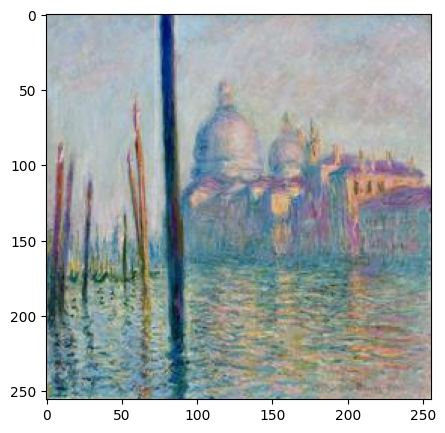

In [14]:
def show_image(image, title=None):
    """Show image with title if provided."""
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)
# Get a batch of training data
data_iter = iter(monet_loader)
images = next(data_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=5)

# Display the images
plt.figure(figsize=(5, 5))  # Adjust figure size as needed
show_image(out)
plt.show()


In [15]:
shape = cv2.imread('/content/monet_jpg/011835cfbf.jpg').shape
shape

(256, 256, 3)

## Model Building

**Generator**

Residual blocks are designed to learn the difference between the input data and the desired output. They achieve this by using two convolutional blocks (ConvBlocks) in a clever way.

The first ConvBlock acts like a feature extractor. It has an activation function, which helps it identify important patterns and non-linear relationships within the input data.

The second ConvBlock aims to learn the remaining changes needed. Without an activation function, it focuses on capturing the specific modifications required to transform the extracted features into the desired output.

By adding the outputs of these two ConvBlocks, the residual block essentially learns the difference (residual) between the original input and the final result. This approach makes it easier for deep neural networks to train effectively, especially with many layers.

The second ConvBlock in a residual block plays a crucial role in capturing the residual information. It does this by having a different design choice compared to the first ConvBlock.

Unlike the first, the second ConvBlock skips the activation function. This allows it to focus on adjusting the dimensions (like the number of channels) of the features extracted earlier.

Without the activation function's influence, the second ConvBlock can learn the residual changes. Instead of creating entirely new features, it modifies the existing ones to get closer to the desired output.

By adding the output of this "dimension-adjusting" ConvBlock directly to the original input, the residual block effectively learns the residual features or the specific adjustments needed to transform the initial data into the final result. This approach simplifies the learning process for deep neural networks, especially with many layers.

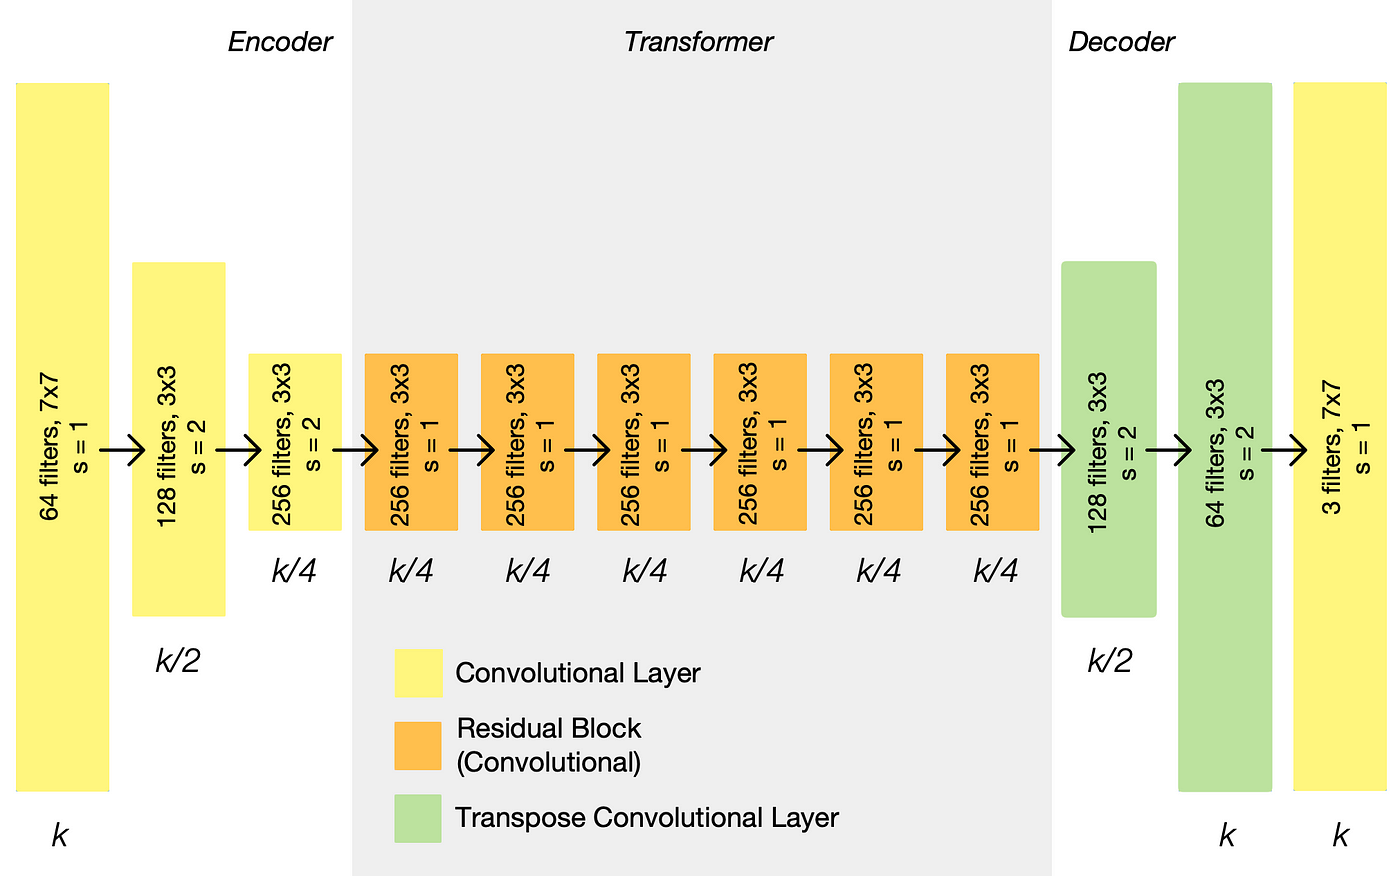

In [16]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [18]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


gen = Generator(3)
print(3)

3





Discriminator

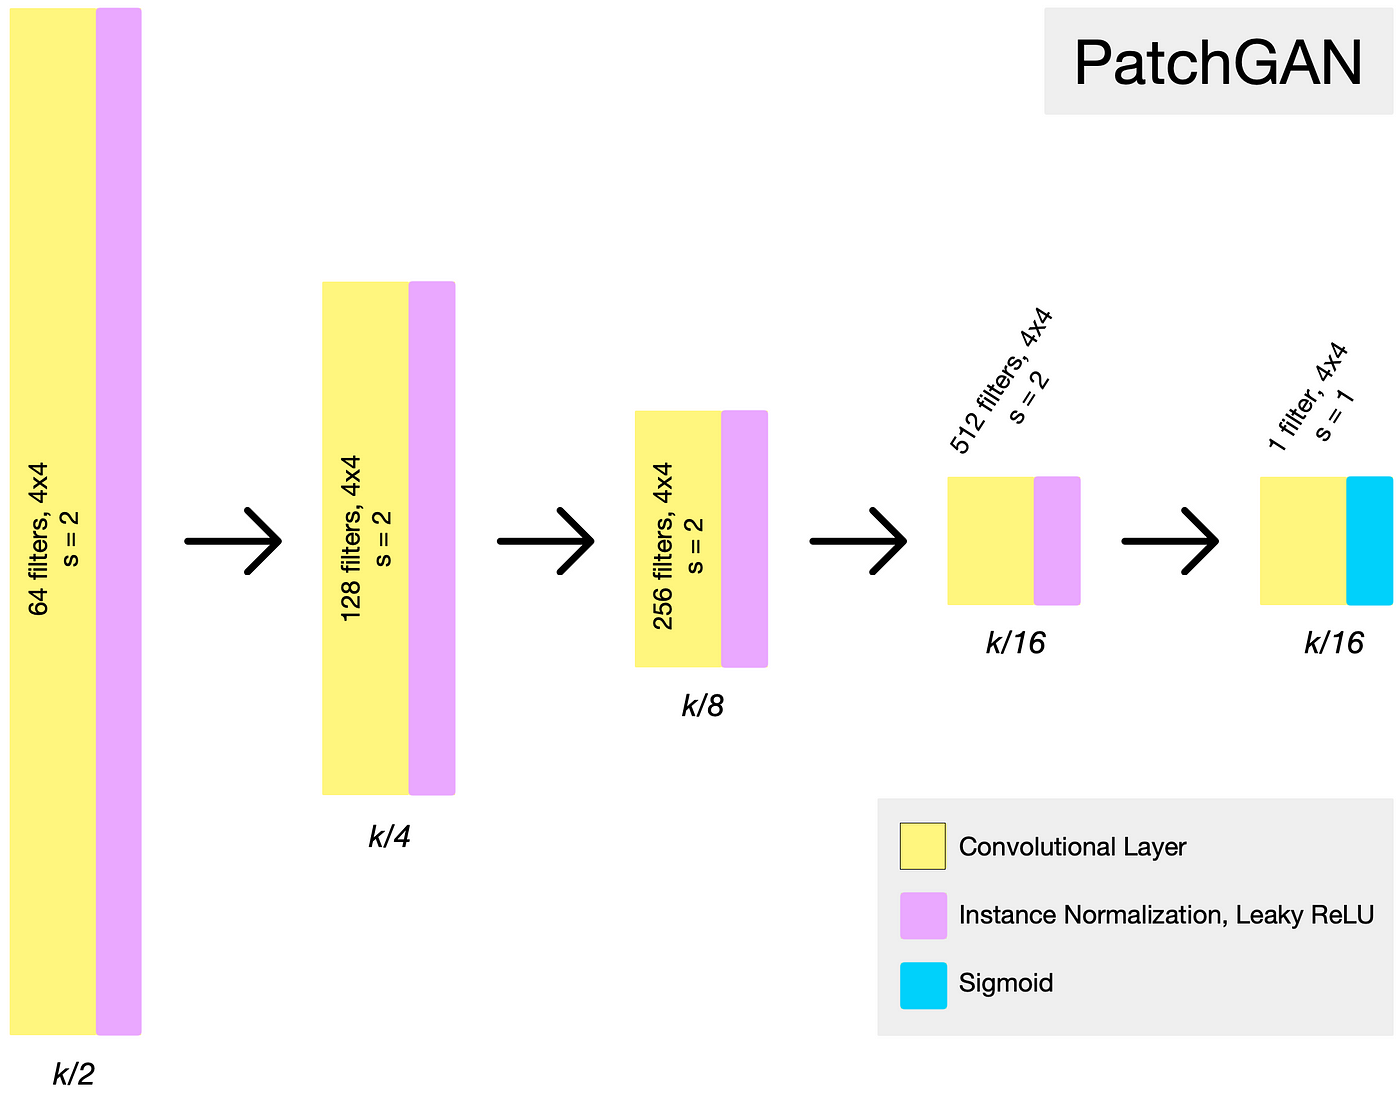

In [19]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))
disc = Discriminator()
print(disc)

Discriminator(
  (initial_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, ke

In [21]:
photo = next(iter(photo_loader))
photo[0].shape

torch.Size([3, 256, 256])

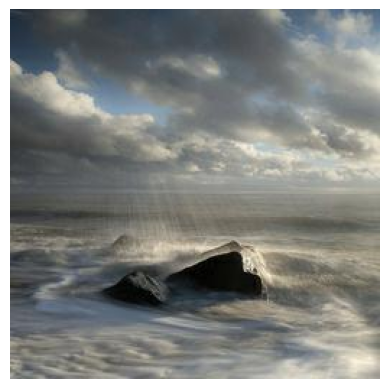

In [22]:
import matplotlib.pyplot as plt

# Assuming `real_images` is your tensor
real_images = next(iter(photo_loader))

# Visualize the first image in the batch
plt.imshow(real_images[0].permute(1, 2, 0))  # since the images are in format (C, H, W)
plt.axis('off')  # Hide axes
plt.show()



In [23]:



# # Create the generator
# latent_dim = 100
# gen = Generator(latent_dim, 3, 64)

# # Sample noise vector
# noise_vector = torch.randn(1, latent_dim)

# # Generate an image
# with torch.no_grad():
#     generated_image = gen(noise_vector)

# def visualize_images(generated_imgs):
#     """
#     Visualizes the generated images.
#     """
#     # Assume the image is in range [-1, 1], convert to [0, 1]
#     img = (generated_imgs.squeeze(0).permute(1, 2, 0) + 1) / 2
#     img = img.cpu().numpy()
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes
#     plt.show()

# # Visualize the generated image
# visualize_images(generated_image)


In [24]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
GPU Device Name: NVIDIA A100-SXM4-40GB


In [25]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"



In [26]:
gen_photo_to_monet = Generator(3)
gen_monet_to_photo = Generator(3)
disc_photo = Discriminator()
disc_monet = Discriminator()

gen_photo_to_monet.to(device)
gen_monet_to_photo.to(device)
disc_photo.to(device)
disc_monet.to(device)

Discriminator(
  (initial_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvInstanceNormLeakyReLUBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, ke

In [27]:
# Initialize a model, and put it on the device specified.
# gen = Generator(latent_dim, img_channels, feature_maps_g)
# dis = Discriminator(img_channels, feature_maps_d)
# gen = gen.to(device)
# dis = dis.to(device)

### Optimizer and Loss

In [28]:
# Loss function
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(
    list(gen_photo_to_monet.parameters()) + list(gen_monet_to_photo.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_photo = torch.optim.Adam(disc_photo.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_monet = torch.optim.Adam(disc_monet.parameters(), lr=2e-4, betas=(0.5, 0.999))



In [29]:
# lr_finder = LRFinder(gen_photo_to_monet, optimizer_G, cycle_loss, device="cuda")
# lr_finder.range_test(photo_loader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()

### Training

In [30]:
for data in photo_loader:
    print(data.size(0))  # Print the number of elements returned
    break

1


In [31]:
num_epochs = 50
# Training loop
g_loss_epoch = []
d_loss_photo_epoch = []
d_loss_monet_epoch = []
for epoch in range(num_epochs):
    g_loss_btch = []
    d_loss_photo_btch = []
    d_loss_monet_btch = []
    for i, (real_photos, real_monets) in enumerate(tqdm(zip(photo_loader, monet_loader), total=min(len(photo_loader), len(monet_loader)))):

        real_photos = real_photos.to(device)
        real_monets = real_monets.to(device)

        # Adversarial ground truths
        valid_photo = torch.ones(real_photos.size(0),1, 1, 1, requires_grad=False).to(device)
        fake_photo = torch.zeros(real_photos.size(0),1, 1, 1, requires_grad=False).to(device)
        valid_monet = torch.ones(real_monets.size(0),1, 1, 1, requires_grad=False).to(device)
        fake_monet = torch.zeros(real_monets.size(0),1, 1, 1, requires_grad=False).to(device)
        # -----------------
        #  Train Generator
        # -----------------

       # Photo to Monet
        fake_monets = gen_photo_to_monet(real_photos)
        output_disc_monet = disc_monet(fake_monets)

        loss_GAN_photo_to_monet = adversarial_loss(disc_monet(fake_monets), valid_photo)

        # Monet to Photo
        fake_photos = gen_monet_to_photo(real_monets)
        loss_GAN_monet_to_photo = adversarial_loss(disc_photo(fake_photos), valid_monet)

        # Cycle consistency
        recovered_photos = gen_monet_to_photo(fake_monets)
        loss_cycle_photo = cycle_loss(recovered_photos, real_photos)

        recovered_monets = gen_photo_to_monet(fake_photos)
        loss_cycle_monet = cycle_loss(recovered_monets, real_monets)

        # Identity loss
        loss_identity_photo = identity_loss(gen_monet_to_photo(real_photos), real_photos)
        loss_identity_monet = identity_loss(gen_photo_to_monet(real_monets), real_monets)

        # Total loss
        loss_G = (loss_GAN_photo_to_monet + loss_GAN_monet_to_photo +
                  10.0 * (loss_cycle_photo + loss_cycle_monet) +
                  5.0 * (loss_identity_photo + loss_identity_monet))

        loss_G.backward()
        optimizer_G.step()

        g_loss_btch.append(loss_G.item())


        # lamba_cycle=10
        # lambda_identity = 5
        # ---------------------
        #  Train Discriminator
        # ---------------------



        # Measure discriminator's ability to classify real from generated samples
        optimizer_D_photo.zero_grad()
        optimizer_D_monet.zero_grad()

        # Discriminator for real and fake photos
        loss_real_photo = adversarial_loss(disc_photo(real_photos), valid_photo)
        loss_fake_photo = adversarial_loss(disc_photo(fake_photos.detach()), fake_photo)
        loss_D_photo = (loss_real_photo + loss_fake_photo) / 2

        # Discriminator for real and fake monets
        loss_real_monet = adversarial_loss(disc_monet(real_monets), valid_monet)
        loss_fake_monet = adversarial_loss(disc_monet(fake_monets.detach()), fake_monet)
        loss_D_monet = (loss_real_monet + loss_fake_monet) / 2

        loss_D_photo.backward()
        loss_D_monet.backward()
        optimizer_D_photo.step()
        optimizer_D_monet.step()


        d_loss_photo_btch.append(loss_D_photo.item())
        d_loss_monet_btch.append(loss_D_monet.item())


    g_loss_act = sum(g_loss_btch)/len(g_loss_btch)
    d_loss_monet_act = sum(d_loss_monet_btch)/len(d_loss_monet_btch)
    d_loss_photo_act = sum(d_loss_photo_btch)/len(d_loss_photo_btch)

    g_loss_epoch.append(g_loss_act)
    d_loss_photo_epoch.append(d_loss_photo_act)
    d_loss_monet_epoch.append(d_loss_monet_act)



    #  Print epoch-wise losses
    if epoch == 0:
        print(f"[Epoch {epoch+1}/{num_epochs}] [D Photo loss: {d_loss_photo_act:.4f}] [D Monet loss: {d_loss_monet_act:.4f}] [G loss: {g_loss_act:.4f}]")
    else:
        print(f"[Epoch {epoch+1}/{num_epochs}] [D Photo loss: {d_loss_photo_epoch[-1]:.4f}] [D Monet loss: {d_loss_monet_epoch[-1]:.4f}] [G loss: {g_loss_epoch[-1]:.4f}]")

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1, 1, 1])) that is different to the input size (torch.Size([1, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1/50] [D Photo loss: 0.1228] [D Monet loss: 0.1234] [G loss: 12.4181]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 2/50] [D Photo loss: 0.1136] [D Monet loss: 0.1141] [G loss: 13.7995]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 3/50] [D Photo loss: 0.1068] [D Monet loss: 0.1072] [G loss: 15.5685]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 4/50] [D Photo loss: 0.1003] [D Monet loss: 0.1007] [G loss: 16.8185]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 5/50] [D Photo loss: 0.0944] [D Monet loss: 0.0945] [G loss: 16.8079]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 6/50] [D Photo loss: 0.0883] [D Monet loss: 0.0887] [G loss: 17.0885]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 7/50] [D Photo loss: 0.0828] [D Monet loss: 0.0831] [G loss: 17.1305]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 8/50] [D Photo loss: 0.0775] [D Monet loss: 0.0779] [G loss: 17.1643]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 9/50] [D Photo loss: 0.0726] [D Monet loss: 0.0729] [G loss: 17.1101]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 10/50] [D Photo loss: 0.0679] [D Monet loss: 0.0683] [G loss: 17.2105]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 11/50] [D Photo loss: 0.0635] [D Monet loss: 0.0638] [G loss: 17.1483]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 12/50] [D Photo loss: 0.0594] [D Monet loss: 0.0597] [G loss: 17.1956]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 13/50] [D Photo loss: 0.0555] [D Monet loss: 0.0558] [G loss: 17.2920]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 14/50] [D Photo loss: 0.0518] [D Monet loss: 0.0521] [G loss: 17.3064]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 15/50] [D Photo loss: 0.0484] [D Monet loss: 0.0486] [G loss: 17.2666]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 16/50] [D Photo loss: 0.0451] [D Monet loss: 0.0453] [G loss: 17.3924]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 17/50] [D Photo loss: 0.0421] [D Monet loss: 0.0423] [G loss: 17.2529]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 18/50] [D Photo loss: 0.0392] [D Monet loss: 0.0394] [G loss: 17.5289]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 19/50] [D Photo loss: 0.0365] [D Monet loss: 0.0367] [G loss: 17.6021]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 20/50] [D Photo loss: 0.0340] [D Monet loss: 0.0342] [G loss: 17.5662]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 21/50] [D Photo loss: 0.0316] [D Monet loss: 0.0318] [G loss: 17.4706]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 22/50] [D Photo loss: 0.0294] [D Monet loss: 0.0296] [G loss: 17.6017]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 23/50] [D Photo loss: 0.0274] [D Monet loss: 0.0275] [G loss: 17.5688]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 24/50] [D Photo loss: 0.0254] [D Monet loss: 0.0256] [G loss: 17.6711]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 25/50] [D Photo loss: 0.0236] [D Monet loss: 0.0238] [G loss: 17.6775]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 26/50] [D Photo loss: 0.0220] [D Monet loss: 0.0221] [G loss: 17.6631]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 27/50] [D Photo loss: 0.0204] [D Monet loss: 0.0205] [G loss: 17.7725]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 28/50] [D Photo loss: 0.0189] [D Monet loss: 0.0190] [G loss: 17.7962]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 29/50] [D Photo loss: 0.0176] [D Monet loss: 0.0177] [G loss: 17.7974]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 30/50] [D Photo loss: 0.0163] [D Monet loss: 0.0164] [G loss: 17.8401]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 31/50] [D Photo loss: 0.0151] [D Monet loss: 0.0152] [G loss: 17.8480]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 32/50] [D Photo loss: 0.0140] [D Monet loss: 0.0141] [G loss: 17.6516]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 33/50] [D Photo loss: 0.0130] [D Monet loss: 0.0130] [G loss: 17.8936]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 34/50] [D Photo loss: 0.0120] [D Monet loss: 0.0121] [G loss: 17.7019]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 35/50] [D Photo loss: 0.0111] [D Monet loss: 0.0112] [G loss: 17.9658]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 36/50] [D Photo loss: 0.0103] [D Monet loss: 0.0104] [G loss: 18.0632]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 37/50] [D Photo loss: 0.0096] [D Monet loss: 0.0096] [G loss: 17.9363]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 38/50] [D Photo loss: 0.0088] [D Monet loss: 0.0089] [G loss: 17.7586]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 39/50] [D Photo loss: 0.0082] [D Monet loss: 0.0082] [G loss: 17.7615]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 40/50] [D Photo loss: 0.0076] [D Monet loss: 0.0076] [G loss: 17.9114]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 41/50] [D Photo loss: 0.0070] [D Monet loss: 0.0070] [G loss: 17.7457]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 42/50] [D Photo loss: 0.0065] [D Monet loss: 0.0065] [G loss: 17.8999]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 43/50] [D Photo loss: 0.0060] [D Monet loss: 0.0060] [G loss: 17.7841]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 44/50] [D Photo loss: 0.0056] [D Monet loss: 0.0056] [G loss: 17.9201]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 45/50] [D Photo loss: 0.0051] [D Monet loss: 0.0051] [G loss: 17.9869]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 46/50] [D Photo loss: 0.0047] [D Monet loss: 0.0048] [G loss: 17.9788]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 47/50] [D Photo loss: 0.0044] [D Monet loss: 0.0044] [G loss: 17.9403]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 48/50] [D Photo loss: 0.0041] [D Monet loss: 0.0041] [G loss: 18.0319]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 49/50] [D Photo loss: 0.0037] [D Monet loss: 0.0037] [G loss: 18.1520]


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 50/50] [D Photo loss: 0.0035] [D Monet loss: 0.0035] [G loss: 18.2396]


G_loss: As the generator learns to produce more realistic images, its loss decreases. This happens because the generator becomes better at fooling the discriminator.

D_loss: As the generator improves, the discriminator faces a more challenging task, and its loss may start to increase again. This happens because the discriminator finds it harder to differentiate between real and fake images.

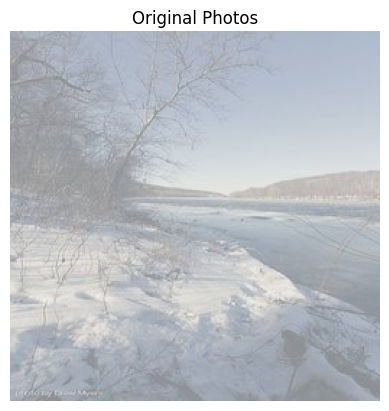

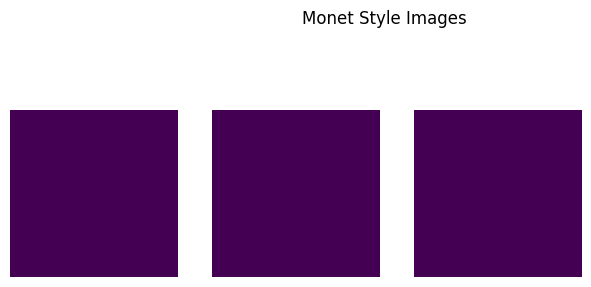

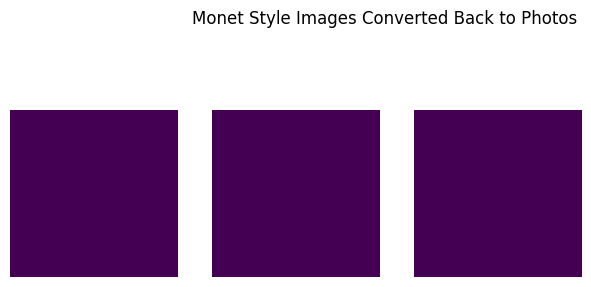

torch.Size([3, 256, 256])


In [32]:
import matplotlib.pyplot as plt

def visualize_images(images, title="Generated Images"):
    # images.size()
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow((images[i].permute(0, 1).cpu().numpy() + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize original photos
real_photos = next(iter(photo_loader))[0].to(device)
plt.imshow((real_photos.permute(1, 2, 0).cpu().numpy() + 1) / 2)
plt.axis('off')
plt.title("Original Photos")
plt.show()

# Generate and visualize Monet style images
with torch.no_grad():
    monet_style_images = gen_photo_to_monet(real_photos)
    monet_style_images.size()
visualize_images(monet_style_images, title="Monet Style Images")

# Visualize Monet style images converted back to photos
real_photos_monet = next(iter(monet_loader))[0].to(device)
with torch.no_grad():
    photo_style_images = gen_monet_to_photo(real_photos_monet)
visualize_images(photo_style_images, title="Monet Style Images Converted Back to Photos")

print(monet_style_images.size())


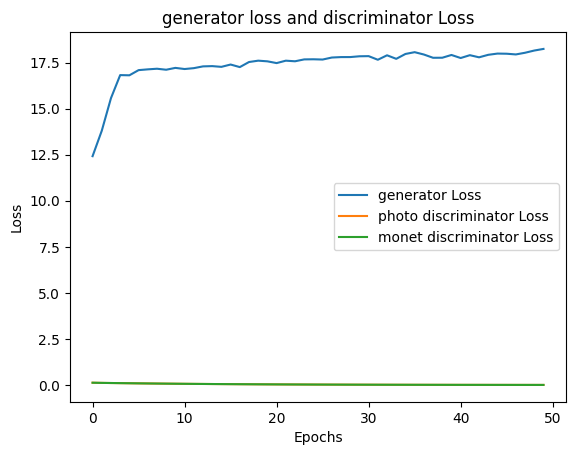

In [33]:
# Plotting the loss curves
plt.figure()
plt.plot(g_loss_epoch, label='generator Loss')
plt.plot(d_loss_photo_epoch, label='photo discriminator Loss')
plt.plot(d_loss_monet_epoch, label='monet discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('generator loss and discriminator Loss')
plt.legend()
plt.show()

GEN PHOTO UPDATED

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Convolutional Block
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_downsampling=True, add_activation=True, **kwargs):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

# Generator
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=6):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList([
            ConvolutionalBlock(num_features, num_features * 2, kernel_size=3, stride=2, padding=1),
            ConvolutionalBlock(num_features * 2, num_features * 4, kernel_size=3, stride=2, padding=1),
        ])

        self.residual_layers = nn.Sequential(*[ResidualBlock(num_features * 4) for _ in range(num_residuals)])

        self.upsampling_layers = nn.ModuleList([
            ConvolutionalBlock(num_features * 4, num_features * 2, is_downsampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvolutionalBlock(num_features * 2, num_features, is_downsampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
        ])

        self.last_layer = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen_photo_to_monet = Generator(3).to(device)
gen_monet_to_photo = Generator(3).to(device)
disc_photo = Discriminator().to(device)
disc_monet = Discriminator().to(device)

# Updated loss functions to avoid warning issues
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Optimizers with adjusted learning rates
Dlr = 2e-4  # Fixed learning rate for both generator and discriminator
Glr = 1e-4
optimizer_G = optim.Adam(
    list(gen_photo_to_monet.parameters()) + list(gen_monet_to_photo.parameters()),
    lr=Glr, betas=(0.5, 0.999)
)
optimizer_D_photo = optim.Adam(disc_photo.parameters(), lr=Dlr, betas=(0.5, 0.999))
optimizer_D_monet = optim.Adam(disc_monet.parameters(), lr=Dlr, betas=(0.5, 0.999))

num_epochs = 50

# Ground truth tensors correction
def get_labels(tensor):
    return torch.ones_like(tensor), torch.zeros_like(tensor)


In [44]:
from tqdm import tqdm

g_loss_epoch, d_loss_photo_epoch, d_loss_monet_epoch = [], [], []

for epoch in range(num_epochs):
    g_loss_btch, d_loss_photo_btch, d_loss_monet_btch = [], [], []

    for i, (real_photos, real_monets) in enumerate(tqdm(zip(photo_loader, monet_loader), total=min(len(photo_loader), len(monet_loader)))):

        real_photos = real_photos.to(device)
        real_monets = real_monets.to(device)

        # Get correct label shapes
        valid_photo, fake_photo = get_labels(disc_photo(real_photos))
        valid_monet, fake_monet = get_labels(disc_monet(real_monets))

        # Train Generator
        optimizer_G.zero_grad()

        fake_monets = gen_photo_to_monet(real_photos)
        fake_photos = gen_monet_to_photo(real_monets)

        loss_GAN_photo_to_monet = adversarial_loss(disc_monet(fake_monets), valid_photo)
        loss_GAN_monet_to_photo = adversarial_loss(disc_photo(fake_photos), valid_monet)

        # Cycle consistency
        recovered_photos = gen_monet_to_photo(fake_monets)
        recovered_monets = gen_photo_to_monet(fake_photos)
        loss_cycle_photo = cycle_loss(recovered_photos, real_photos)
        loss_cycle_monet = cycle_loss(recovered_monets, real_monets)

        # Identity loss
        loss_identity_photo = identity_loss(gen_monet_to_photo(real_photos), real_photos)
        loss_identity_monet = identity_loss(gen_photo_to_monet(real_monets), real_monets)

        loss_G = (loss_GAN_photo_to_monet + loss_GAN_monet_to_photo +
                  5.0 * (loss_cycle_photo + loss_cycle_monet) +
                  0.5 * (loss_identity_photo + loss_identity_monet))

        loss_G.backward()
        optimizer_G.step()

        g_loss_btch.append(loss_G.item())

        # Train Discriminator
        optimizer_D_photo.zero_grad()
        optimizer_D_monet.zero_grad()

        loss_real_photo = adversarial_loss(disc_photo(real_photos), valid_photo)
        loss_fake_photo = adversarial_loss(disc_photo(fake_photos.detach()), fake_photo)
        loss_D_photo = (loss_real_photo + loss_fake_photo) / 2

        loss_real_monet = adversarial_loss(disc_monet(real_monets), valid_monet)
        loss_fake_monet = adversarial_loss(disc_monet(fake_monets.detach()), fake_monet)
        loss_D_monet = (loss_real_monet + loss_fake_monet) / 2

        loss_D_photo.backward()
        loss_D_monet.backward()
        optimizer_D_photo.step()
        optimizer_D_monet.step()

        d_loss_photo_btch.append(loss_D_photo.item())
        d_loss_monet_btch.append(loss_D_monet.item())

    # Average epoch losses
    g_loss_epoch.append(sum(g_loss_btch) / len(g_loss_btch))
    d_loss_photo_epoch.append(sum(d_loss_photo_btch) / len(d_loss_photo_btch))
    d_loss_monet_epoch.append(sum(d_loss_monet_btch) / len(d_loss_monet_btch))

    print(f"[Epoch {epoch+1}/{num_epochs}] [D Photo loss: {d_loss_photo_epoch[-1]:.4f}] [D Monet loss: {d_loss_monet_epoch[-1]:.4f}] [G loss: {g_loss_epoch[-1]:.4f}]")

    # # Save sample images
    # if (epoch + 1) % 5 == 0:
    #     with torch.no_grad():
    #         fake_monet = gen_photo_to_monet(real_photos[:5])
    #         fake_photo = gen_monet_to_photo(real_monets[:5])
    #         save_image(fake_monet, f"epoch_{epoch+1}_fake_monet.png", normalize=True)
    #         save_image(fake_photo, f"epoch_{epoch+1}_fake_photo.png", normalize=True)


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 1/50] [D Photo loss: 0.2320] [D Monet loss: 0.2118] [G loss: 1.7955]


100%|██████████| 300/300 [00:27<00:00, 10.85it/s]


[Epoch 2/50] [D Photo loss: 0.2252] [D Monet loss: 0.2096] [G loss: 1.7572]


100%|██████████| 300/300 [00:27<00:00, 10.85it/s]


[Epoch 3/50] [D Photo loss: 0.2282] [D Monet loss: 0.2150] [G loss: 1.7519]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 4/50] [D Photo loss: 0.2304] [D Monet loss: 0.2118] [G loss: 1.7325]


100%|██████████| 300/300 [00:27<00:00, 10.80it/s]


[Epoch 5/50] [D Photo loss: 0.2273] [D Monet loss: 0.2102] [G loss: 1.8010]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 6/50] [D Photo loss: 0.2333] [D Monet loss: 0.2148] [G loss: 1.7483]


100%|██████████| 300/300 [00:27<00:00, 10.76it/s]


[Epoch 7/50] [D Photo loss: 0.2259] [D Monet loss: 0.2146] [G loss: 1.7679]


100%|██████████| 300/300 [00:27<00:00, 10.88it/s]


[Epoch 8/50] [D Photo loss: 0.2253] [D Monet loss: 0.2108] [G loss: 1.7692]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 9/50] [D Photo loss: 0.2240] [D Monet loss: 0.2104] [G loss: 1.7790]


100%|██████████| 300/300 [00:27<00:00, 10.79it/s]


[Epoch 10/50] [D Photo loss: 0.2236] [D Monet loss: 0.2039] [G loss: 1.8120]


100%|██████████| 300/300 [00:27<00:00, 10.87it/s]


[Epoch 11/50] [D Photo loss: 0.2212] [D Monet loss: 0.2080] [G loss: 1.7794]


100%|██████████| 300/300 [00:27<00:00, 10.87it/s]


[Epoch 12/50] [D Photo loss: 0.2184] [D Monet loss: 0.1985] [G loss: 1.8325]


100%|██████████| 300/300 [00:27<00:00, 10.76it/s]


[Epoch 13/50] [D Photo loss: 0.2282] [D Monet loss: 0.2045] [G loss: 1.8107]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 14/50] [D Photo loss: 0.2267] [D Monet loss: 0.2071] [G loss: 1.7975]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 15/50] [D Photo loss: 0.2284] [D Monet loss: 0.1981] [G loss: 1.8015]


100%|██████████| 300/300 [00:27<00:00, 10.86it/s]


[Epoch 16/50] [D Photo loss: 0.2329] [D Monet loss: 0.2082] [G loss: 1.7629]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 17/50] [D Photo loss: 0.2334] [D Monet loss: 0.2012] [G loss: 1.7718]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 18/50] [D Photo loss: 0.2304] [D Monet loss: 0.2057] [G loss: 1.7614]


100%|██████████| 300/300 [00:27<00:00, 10.79it/s]


[Epoch 19/50] [D Photo loss: 0.2241] [D Monet loss: 0.1947] [G loss: 1.8599]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 20/50] [D Photo loss: 0.2391] [D Monet loss: 0.1963] [G loss: 1.7629]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 21/50] [D Photo loss: 0.2324] [D Monet loss: 0.1983] [G loss: 1.7734]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 22/50] [D Photo loss: 0.2313] [D Monet loss: 0.2048] [G loss: 1.7492]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 23/50] [D Photo loss: 0.2275] [D Monet loss: 0.1802] [G loss: 1.8003]


100%|██████████| 300/300 [00:27<00:00, 10.86it/s]


[Epoch 24/50] [D Photo loss: 0.2224] [D Monet loss: 0.1887] [G loss: 1.8211]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 25/50] [D Photo loss: 0.2282] [D Monet loss: 0.1796] [G loss: 1.8018]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 26/50] [D Photo loss: 0.2317] [D Monet loss: 0.1803] [G loss: 1.8032]


100%|██████████| 300/300 [00:27<00:00, 10.79it/s]


[Epoch 27/50] [D Photo loss: 0.2244] [D Monet loss: 0.1713] [G loss: 1.8020]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 28/50] [D Photo loss: 0.2293] [D Monet loss: 0.1776] [G loss: 1.7949]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 29/50] [D Photo loss: 0.2284] [D Monet loss: 0.1792] [G loss: 1.8131]


100%|██████████| 300/300 [00:27<00:00, 10.79it/s]


[Epoch 30/50] [D Photo loss: 0.2279] [D Monet loss: 0.1771] [G loss: 1.7976]


100%|██████████| 300/300 [00:27<00:00, 10.80it/s]


[Epoch 31/50] [D Photo loss: 0.2311] [D Monet loss: 0.1710] [G loss: 1.7775]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 32/50] [D Photo loss: 0.2349] [D Monet loss: 0.1625] [G loss: 1.7947]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 33/50] [D Photo loss: 0.2302] [D Monet loss: 0.1518] [G loss: 1.8032]


100%|██████████| 300/300 [00:27<00:00, 10.80it/s]


[Epoch 34/50] [D Photo loss: 0.2302] [D Monet loss: 0.1456] [G loss: 1.8347]


100%|██████████| 300/300 [00:27<00:00, 10.78it/s]


[Epoch 35/50] [D Photo loss: 0.2352] [D Monet loss: 0.1531] [G loss: 1.7751]


100%|██████████| 300/300 [00:27<00:00, 10.75it/s]


[Epoch 36/50] [D Photo loss: 0.2307] [D Monet loss: 0.1477] [G loss: 1.8186]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 37/50] [D Photo loss: 0.2327] [D Monet loss: 0.1518] [G loss: 1.8397]


100%|██████████| 300/300 [00:27<00:00, 10.76it/s]


[Epoch 38/50] [D Photo loss: 0.2376] [D Monet loss: 0.1584] [G loss: 1.7929]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 39/50] [D Photo loss: 0.2358] [D Monet loss: 0.1567] [G loss: 1.7928]


100%|██████████| 300/300 [00:27<00:00, 10.84it/s]


[Epoch 40/50] [D Photo loss: 0.2303] [D Monet loss: 0.1545] [G loss: 1.8129]


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[Epoch 41/50] [D Photo loss: 0.2295] [D Monet loss: 0.1556] [G loss: 1.8347]


100%|██████████| 300/300 [00:27<00:00, 10.86it/s]


[Epoch 42/50] [D Photo loss: 0.2305] [D Monet loss: 0.1476] [G loss: 1.8536]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 43/50] [D Photo loss: 0.2291] [D Monet loss: 0.1540] [G loss: 1.8146]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 44/50] [D Photo loss: 0.2301] [D Monet loss: 0.1496] [G loss: 1.8033]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 45/50] [D Photo loss: 0.2302] [D Monet loss: 0.1441] [G loss: 1.8570]


100%|██████████| 300/300 [00:27<00:00, 10.76it/s]


[Epoch 46/50] [D Photo loss: 0.2287] [D Monet loss: 0.1429] [G loss: 1.8554]


100%|██████████| 300/300 [00:27<00:00, 10.76it/s]


[Epoch 47/50] [D Photo loss: 0.2300] [D Monet loss: 0.1540] [G loss: 1.8086]


100%|██████████| 300/300 [00:27<00:00, 10.86it/s]


[Epoch 48/50] [D Photo loss: 0.2295] [D Monet loss: 0.1416] [G loss: 1.8370]


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


[Epoch 49/50] [D Photo loss: 0.2331] [D Monet loss: 0.1431] [G loss: 1.8168]


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


[Epoch 50/50] [D Photo loss: 0.2324] [D Monet loss: 0.1383] [G loss: 1.8462]


In [47]:
import torchvision.utils as vutils
import os

# Create a folder to store results
os.makedirs("generated_images", exist_ok=True)

# Function to save images
def save_sample_images(epoch, real_photos, real_monets):
    with torch.no_grad():
        fake_monet = gen_photo_to_monet(real_photos[:5])
        fake_photo = gen_monet_to_photo(real_monets[:5])

        # Save real and generated images side by side
        vutils.save_image(real_photos[:5], f"generated_images/epoch_{epoch}_real_photo.png", normalize=True)
        vutils.save_image(fake_monet, f"generated_images/epoch_{epoch}_fake_monet.png", normalize=True)
        vutils.save_image(real_monets[:5], f"generated_images/epoch_{epoch}_real_monet.png", normalize=True)
        vutils.save_image(fake_photo, f"generated_images/epoch_{epoch}_fake_photo.png", normalize=True)

# Call this function every 5 epochs
if (epoch + 1) % 5 == 0:
    save_sample_images(epoch, real_photos, real_monets)


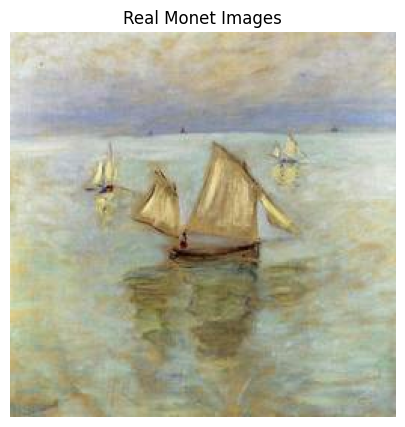

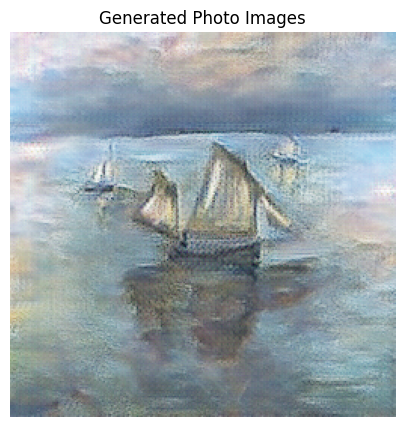

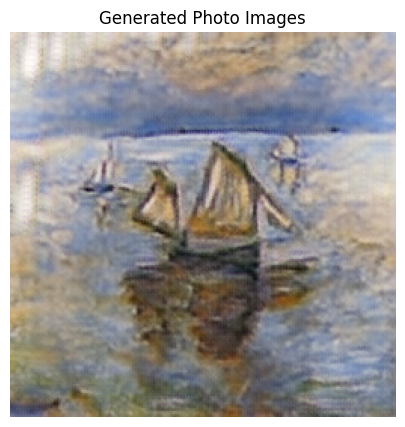

In [55]:
import matplotlib.pyplot as plt

def show_images(images, title="Generated Images"):
    grid = vutils.make_grid(images[:5], normalize=True)
    plt.figure(figsize=(10,5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Inside training loop
with torch.no_grad():
    fake_monet = gen_photo_to_monet(real_photos[:5])
    fake_photo = gen_monet_to_photo(real_monets[:5])
    # fk = gen_photo_to_monet(fake_photo)

    show_images(real_photos[:5], "Real Photo Images")
    show_images(fake_monet, "Generated Monet Images")
    show_images(real_monets[:5], "Real Monet Images")
    show_images(fake_photo, "Generated Photo Images")
    # show_images(fk, "Generated Photo Images")


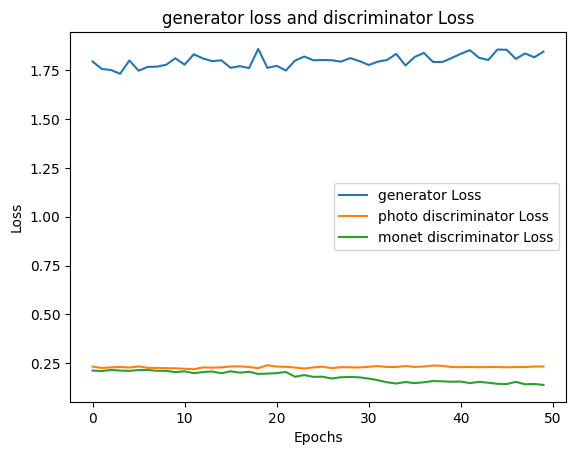

In [46]:
# Plotting the loss curves
plt.figure()
plt.plot(g_loss_epoch, label='generator Loss')
plt.plot(d_loss_photo_epoch, label='photo discriminator Loss')
plt.plot(d_loss_monet_epoch, label='monet discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('generator loss and discriminator Loss')
plt.legend()
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

class CycleGan(nn.Module):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator.to(device)
        self.p_gen = photo_generator.to(device)
        self.m_disc = monet_discriminator.to(device)
        self.p_disc = photo_discriminator.to(device)
        self.lambda_cycle = lambda_cycle

    def forward(self, real_monet, real_photo):

        fake_monet = self.m_gen(real_photo)
        cycled_photo = self.p_gen(fake_monet)
        fake_photo = self.p_gen(real_monet)
        cycled_monet = self.m_gen(fake_photo)
        same_monet = self.m_gen(real_monet)
        same_photo = self.p_gen(real_photo)
        return fake_monet, cycled_photo, fake_photo, cycled_monet, same_monet, same_photo

# Create instances of your generator and discriminator models
monet_generator = Generator(3)
photo_generator = Generator(3)
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

# Define optimizer
monet_generator_optimizer = optim.Adam(monet_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
photo_generator_optimizer = optim.Adam(photo_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
monet_discriminator_optimizer = optim.Adam(monet_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
photo_discriminator_optimizer = optim.Adam(photo_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Define loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Training loop
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

for epoch in range(num_epochs):
    for real_monet, real_photo in zip(monet_loader, photo_loader):
        real_monet = real_monet.to(device)
        real_photo = real_photo.to(device)

        # Forward pass
        fake_monet, cycled_photo, fake_photo, cycled_monet, same_monet, same_photo = cycle_gan_model(real_monet, real_photo)

        # Generator loss
        monet_gen_loss = generator_loss(monet_discriminator(fake_monet))
        photo_gen_loss = generator_loss(photo_discriminator(fake_photo))

        lambda_cycle=10
        # Cycle consistency loss
        cycle_loss_monet = calc_cycle_loss(real_monet, cycled_monet, lambda_cycle)
        cycle_loss_photo = calc_cycle_loss(real_photo, cycled_photo, lambda_cycle)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, same_monet)
        identity_loss_photo = identity_loss(real_photo, same_photo)

        # Total generator loss
        total_monet_gen_loss = monet_gen_loss + cycle_loss_monet + identity_loss_monet
        total_photo_gen_loss = photo_gen_loss + cycle_loss_photo + identity_loss_photo

        # Discriminator loss
        monet_disc_loss = discriminator_loss(monet_discriminator(real_monet), monet_discriminator(fake_monet))
        photo_disc_loss = discriminator_loss(photo_discriminator(real_photo), photo_discriminator(fake_photo))

        # Update generators
        monet_generator_optimizer.zero_grad()
        total_monet_gen_loss.backward()
        monet_generator_optimizer.step()

        photo_generator_optimizer.zero_grad()
        # total_photo_gen_loss.backward(retain_graph=True)
        photo_generator_optimizer.step()

        # Update discriminators
        monet_discriminator_optimizer.zero_grad()
        # monet_disc_loss.backward()
        monet_discriminator_optimizer.step()

        photo_discriminator_optimizer.zero_grad()
        # photo_disc_loss.backward()
        photo_discriminator_optimizer.step()



In [38]:
# CycleGan()

TypeError: CycleGan.__init__() missing 4 required positional arguments: 'monet_generator', 'photo_generator', 'monet_discriminator', and 'photo_discriminator'

In [ ]:
train_cycle_gan(
    cycle_gan_model,
    monet_loader,
    photo_loader,
    num_epochs=EPOCHS_NUM,
    device=device
)

In [ ]:
def visualizing(photos_data, monet_generator, photo_generator, num_images=5):
    fig, ax = plt.subplots( num_images, 3, figsize=(12*3, 12*num_images))
    fake_monet_features = []
    real_monet_features = []

    #for i, photo in enumerate(photo_data.take(num_images)):
    total_images = len(list(photos_data))
    random_indices = random.sample(range(total_images), num_images)

    for i, idx in enumerate(random_indices):
        photo = next(iter(photos_data.skip(idx).take(1)))
        photo_monet = monet_generator(photo, training=False)
        cycle_photo = photo_generator(photo_monet, training=False)
        photo_monet = photo_monet[0].numpy()
        photo_monet = (photo_monet * 127.5 + 127.5).astype(np.uint8)
        cycle_photo = cycle_photo[0].numpy()
        cycle_photo = (cycle_photo * 127.5 + 127.5).astype(np.uint8)
        photo = (photo[0] * 127.5 + 127.5).numpy().astype(np.uint8)


        ax[i, 0].imshow(photo)
        ax[i, 1].imshow(photo_monet)
        ax[i, 2].imshow(cycle_photo)

        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-style Photo")
        ax[i, 2].set_title("Cycled Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        ax[i, 2].axis("off")

    plt.show()

In [ ]:
monet_generator = gen_photo_to_monet(real_photos)

In [ ]:
photo_generator = gen_monet_to_photo(real_photos)

In [ ]:
visualizing(real_photos, monet_generator, photo_generator)

https://www.kaggle.com/code/meetnagadia/handwritten-digits-generator-with-a-gan

generation of handwritings